In [41]:
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
!pip install opencv-python-headless


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import matplotlib.pyplot as plt  # Library for plotting and visualizing data
import numpy as np  # Fundamental package for numerical computations and handling arrays
import os  # Module for interacting with the operating system
import tensorflow as tf  # TensorFlow, a comprehensive open-source platform for machine learning
import tensorflow.keras.layers as tfl  # Keras API for building and training neural networks
from tensorflow.keras.layers import Layer

# Functions for loading and augmenting image datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Load images from a directory and create a dataset
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast  # Layers for random image augmentations
from tensorflow.keras.regularizers import l2  # Apply L2 regularization to layers

# PIL (Python Imaging Library) for image processing
from PIL import ImageEnhance  # Module to enhance images (adjust brightness, contrast, sharpness, color)
from PIL import Image  # Module for opening, manipulating, and saving image files
import cv2
import seaborn as sns



Loading images from a specified directory.

Automatically inferring labels from subdirectory names.

Shuffling and batching the images.

Resizing images to a consistent size.

Splitting the data into training and validation sets.

Verifying the dataset structure by printing out class names and inspecting a batch of images and labels.

# PREPROCESSING

In [44]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = r"C:\Users\email\OneDrive - Lambton College\T3\PROJECT\2025W-T3 BDM 3035\Dataset\organized"

# Install OpenCV if not already installed
# !pip install opencv-python

import os
import matplotlib.pyplot as plt
import numpy as np
# Helper function to load images
def load_images(directory, max_images=None):
    image_paths = []
    class_names = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(root, file))
                class_names.append(os.path.basename(root))
                if max_images and len(image_paths) >= max_images:
                    break
    return image_paths, class_names

# Load images
image_paths, class_names = load_images(directory, max_images=1000)  # Adjust max_images as needed
unique_classes = list(set(class_names))

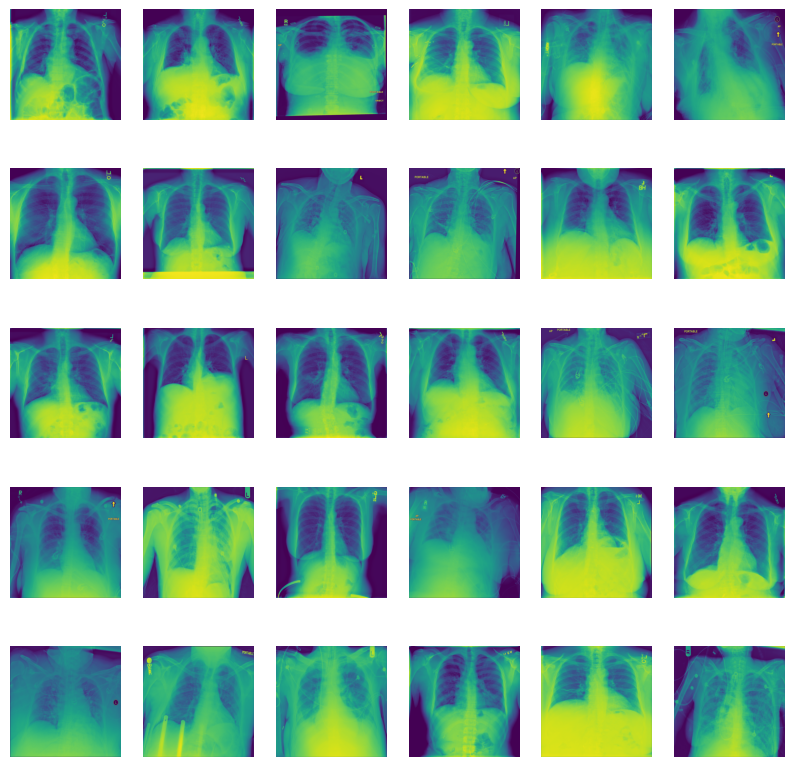

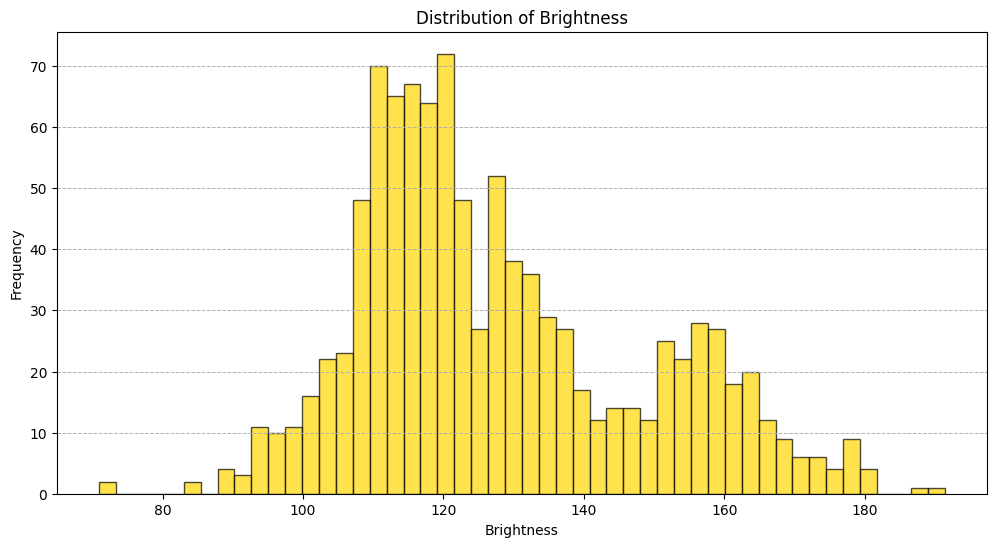

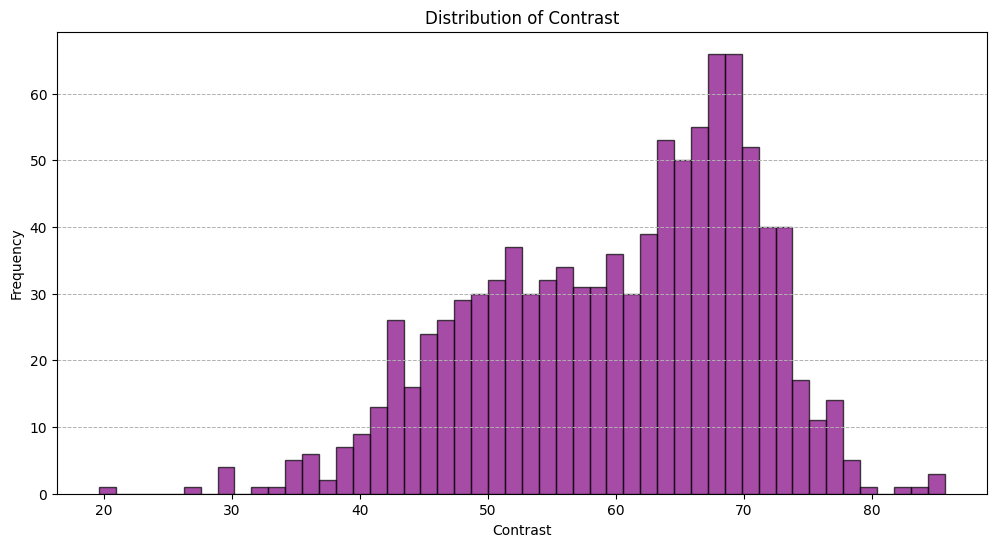

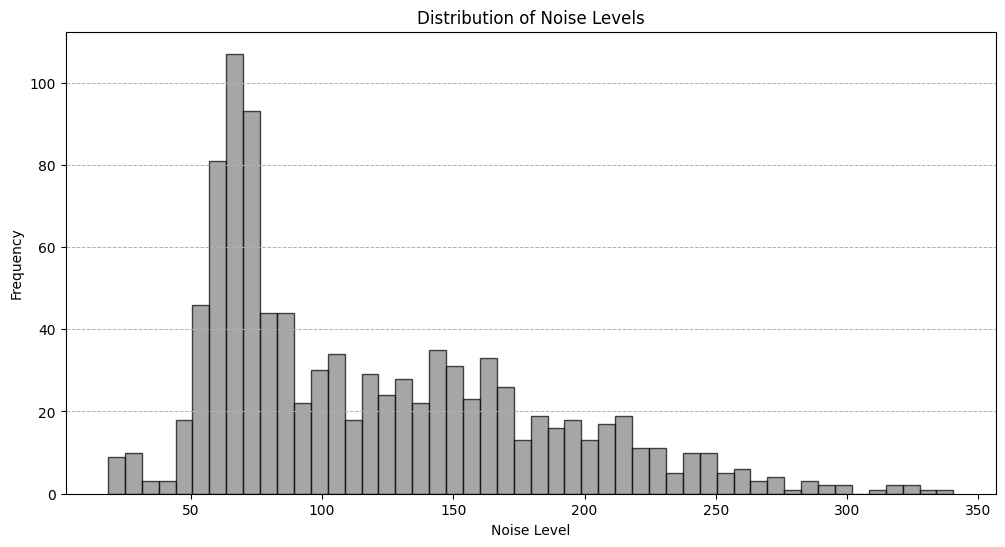

In [45]:
# EDA: Visualize a few images from the dataset
def show_images(image_paths, num_images=30):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        img = Image.open(image_paths[i])
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

show_images(image_paths)

# EDA: Analyze brightness and contrast distributions
def analyze_brightness_contrast(image_paths):
    brightness = []
    contrast = []
    for path in image_paths:
        img = Image.open(path).convert('L')  # Convert image to grayscale
        img = np.array(img)
        brightness.append(np.mean(img))
        contrast.append(np.std(img))
    return brightness, contrast

brightness, contrast = analyze_brightness_contrast(image_paths)

# Plot brightness and contrast distributions
plt.figure(figsize=(12, 6))
plt.hist(brightness, bins=50, alpha=0.7, label='Brightness', color='gold', edgecolor='black')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Distribution of Brightness')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(contrast, bins=50, alpha=0.7, label='Contrast', color='purple', edgecolor='black')
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.title('Distribution of Contrast')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

# EDA: Analyze color distribution
def analyze_color_distribution(image_paths):
    color_means = []
    color_stds = []
    for path in image_paths:
        img = Image.open(path)
        img = np.array(img)
        color_means.append(np.mean(img, axis=(0, 1)))
        color_stds.append(np.std(img, axis=(0, 1)))
    return color_means, color_stds

color_means, color_stds = analyze_color_distribution(image_paths)

# EDA: Identify and visualize noisy images
def analyze_noise(image_paths):
    noise_levels = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        noise = cv2.Laplacian(img, cv2.CV_64F).var()
        noise_levels.append(noise)
    return noise_levels

noise_levels = analyze_noise(image_paths)

# Plot noise levels distribution
plt.figure(figsize=(12, 6))
plt.hist(noise_levels, bins=50, alpha=0.7, label='Noise Level', color='grey', edgecolor='black')
plt.xlabel('Noise Level')
plt.ylabel('Frequency')
plt.title('Distribution of Noise Levels')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

# TRAIN

In [46]:
# Define the training dataset
train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,  # Shuffle the dataset to ensure random distribution
    batch_size=BATCH_SIZE,  # Number of images to process in a single batch
    image_size=IMG_SIZE,  # Resize all images to 224x224 pixels
    validation_split=0.2,  # Reserve 20% of the data for validation
    subset='training',  # This dataset is for training
    seed=42  # Random seed for reproducibility
)

# Define the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,  # Shuffle the dataset to ensure random distribution
    batch_size=BATCH_SIZE,  # Number of images to process in a single batch
    image_size=IMG_SIZE,  # Resize all images to 224x224 pixels
    validation_split=0.2,  # Reserve 20% of the data for validation
    subset='validation',  # This dataset is for validation
    seed=42  # Random seed for reproducibility
)

Found 12396 files belonging to 9 classes.
Using 9917 files for training.
Found 12396 files belonging to 9 classes.
Using 2479 files for validation.


In [ ]:
# Verify the dataset structure
class_names = train_dataset.class_names  # Retrieve the class names inferred from the subdirectory names

# Print each Disease class name on a new line
num_classes = len(class_names)
print(f"Number of Disease classes: {num_classes}")
print("Disease class names:")
for class_name in class_names:
    print(class_name)

Number of waste classes: 9
Waste class names:
Atelectasis
Cardiomegaly
Consolidation
Effusion
Infiltration
Mass
Nodule
Pleural_Thickening
Pneumothorax


# VIZ

Exploring the image quality -- checking the low, high and average image quality

Visualizing the class distribution in both traning and validation dataset.

Image Augmentation -- Image augmentation is performed to enhance the training dataset for machine learning models, particularly in the context of computer vision tasks such as image classification, object detection, and segmentation.

RandomFlip -- Helps the model learn invariant features, improving its ability to recognize objects regardless of their orientation.

RandomRotation -- Enhances the model's robustness to rotation variations, making it more effective at recognizing objects in different orientations.

RandomZoom -- Helps the model handle scale variations, which is important for detecting objects of varying sizes in the input images.

RandomContrast -- Improves the model's ability to handle different lighting conditions and contrasts, making it more robust to changes in illumination.

RandomBrightness -- Enhances the model's robustness to lighting variations, ensuring it can accurately recognize objects in different lighting conditions.

RandomSharpness -- Sharpness adjustments can help the model learn to detect edges and fine details more effectively, which is crucial for tasks requiring high precision, such as medical imaging.

RandomNoise -- Noise addition helps the model become more robust to imperfections and noise in real-world data, which can improve generalization.

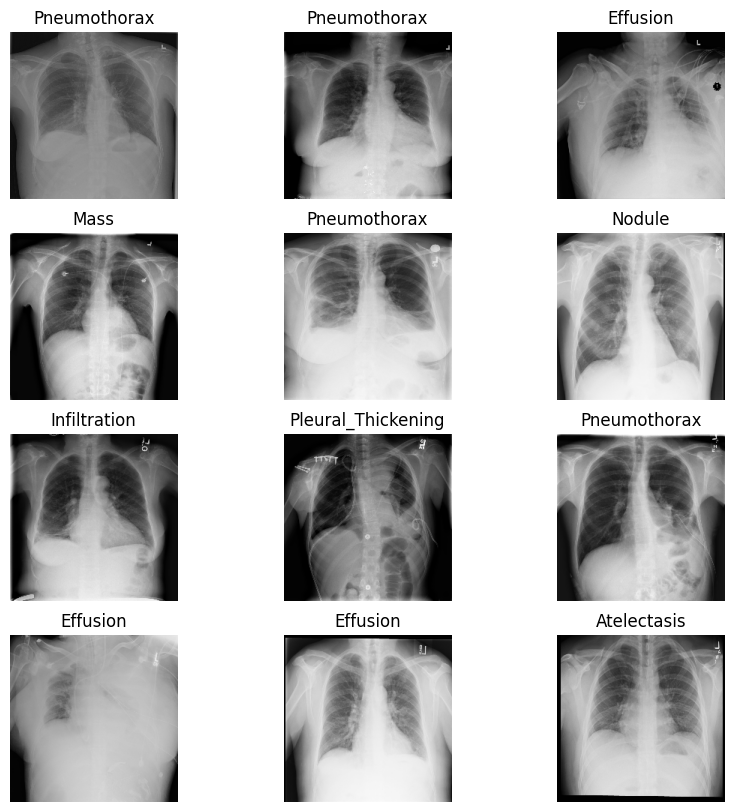

In [48]:
plt.figure(figsize=(10, 10))  # Set the figure size for the plot

# Iterate over the first 2 batches from the training dataset
for images, labels in train_dataset.take(2):
    # Plot 12 images from the current batch
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)  # Create a subplot in a 4x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (class)
        plt.title(class_names[label_index])  # Set the title to the class name
        plt.axis("off")  # Hide the axis

plt.show()  # Display the plot

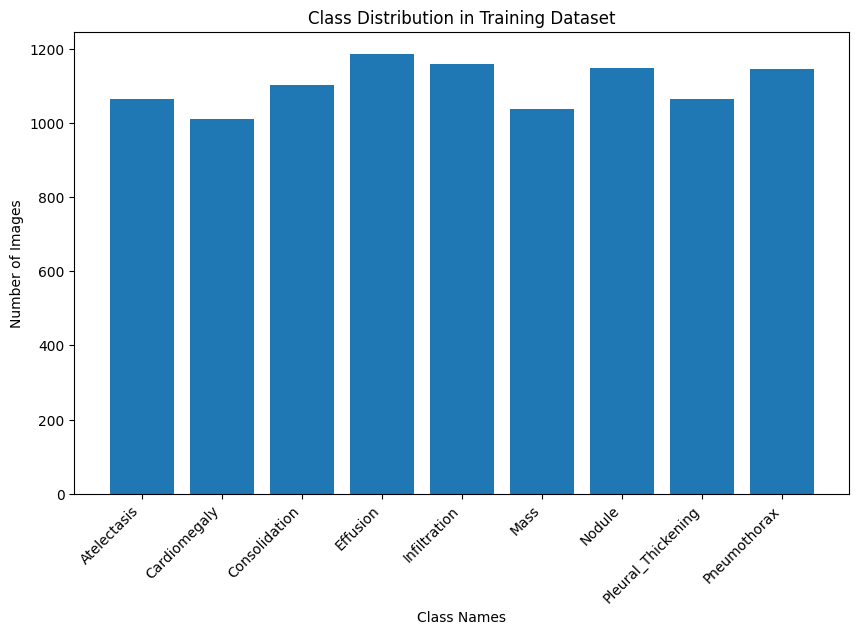

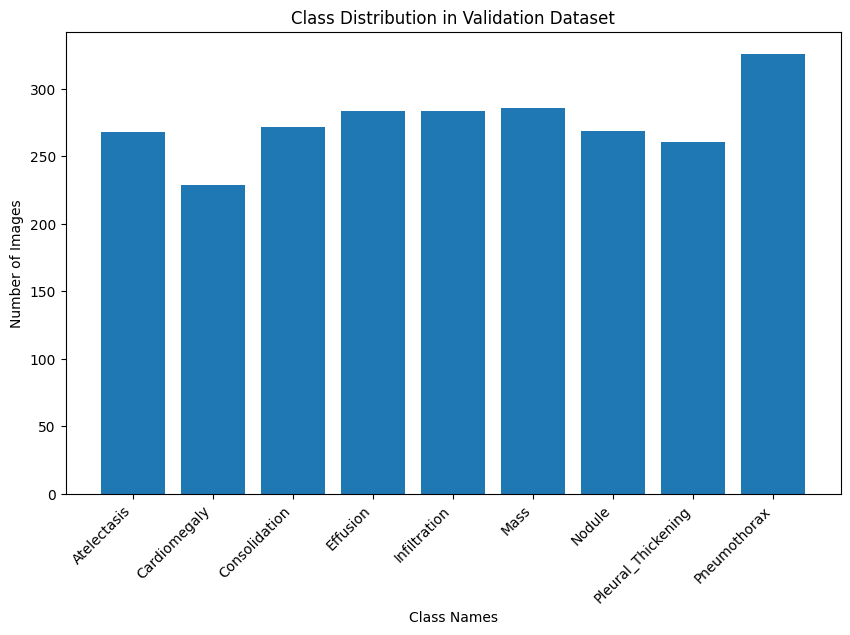

In [49]:
# Check class distribution in the training dataset
class_counts = {class_name: 0 for class_name in class_names}  # Initialize a dictionary to store counts for each class
for _, labels in train_dataset:  # Iterate through batches in the training dataset
    for label in labels:  # Iterate through labels in each batch
        class_index = tf.argmax(label).numpy()  # Get the index of the highest value (class)
        class_name = class_names[class_index]  # Get the class name corresponding to the index
        class_counts[class_name] += 1  # Increment the count for the class

# Plot class distribution for the training dataset
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
plt.bar(class_counts.keys(), class_counts.values())  # Create a bar plot of class counts
plt.xlabel('Class Names')  # Set the label for the x-axis
plt.ylabel('Number of Images')  # Set the label for the y-axis
plt.title('Class Distribution in Training Dataset')  # Set the title of the plot
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.show()  # Display the plot

# Check class distribution in the validation dataset
class_counts = {class_name: 0 for class_name in class_names}  # Reinitialize the dictionary for validation dataset
for _, labels in validation_dataset:  # Iterate through batches in the validation dataset
    for label in labels:  # Iterate through labels in each batch
        class_index = tf.argmax(label).numpy()  # Get the index of the highest value (class)
        class_name = class_names[class_index]  # Get the class name corresponding to the index
        class_counts[class_name] += 1  # Increment the count for the class

# Plot class distribution for the validation dataset
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
plt.bar(class_counts.keys(), class_counts.values())  # Create a bar plot of class counts
plt.xlabel('Class Names')  # Set the label for the x-axis
plt.ylabel('Number of Images')  # Set the label for the y-axis
plt.title('Class Distribution in Validation Dataset')  # Set the title of the plot
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.show()  # Display the plot

In [56]:
# Function to assess image quality for a single image
def assess_image_quality(image):
        # Convert PIL Image to numpy array and then to TensorFlow tensor
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.expand_dims(image, axis=0)  # Add batch dimension

        # Ensure image is in RGB format if required
        if image.shape[-1] != 3:
            image = tf.image.grayscale_to_rgb(image)

        # Apply Sobel edges operation
        edge_image = tf.image.sobel_edges(image)

        # Calculate edge magnitude
        edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(edge_image), axis=-1))

        # Calculate quality score as the mean edge magnitude
        quality_score = tf.reduce_mean(edge_magnitude).numpy()

        return quality_score

# Function to analyze image quality for a dataset
def image_quality_analysis(dataset):
        quality_scores = []
        for image_batch, _ in dataset:  # Iterate directly over the dataset
            for image in image_batch:
                quality_score = assess_image_quality(image)
                quality_scores.append(quality_score)
        return quality_scores

# Example usage for a single image
image_path = r"C:\Users\email\OneDrive - Lambton College\T3\PROJECT\2025W-T3 BDM 3035\Dataset\organized\Atelectasis\00000011_006.png"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))  # Load and resize image
quality_score = assess_image_quality(image)  # Assess quality of a single image
print(f"Single Image Quality Score: {quality_score}")

# Example usage of image_quality_analysis function on a dataset
quality_scores = image_quality_analysis(train_dataset)  # Assess quality of images in the training dataset
print(f"Image Quality Scores: {quality_scores}")


Single Image Quality Score: 49.15460968017578
Image Quality Scores: [np.float32(20.492165), np.float32(37.751976), np.float32(21.318855), np.float32(27.570522), np.float32(27.741999), np.float32(40.635628), np.float32(40.090607), np.float32(25.831177), np.float32(38.245823), np.float32(26.474466), np.float32(45.641525), np.float32(45.386604), np.float32(50.7302), np.float32(35.755486), np.float32(29.492426), np.float32(17.396206), np.float32(34.309593), np.float32(54.018833), np.float32(36.41496), np.float32(20.05436), np.float32(38.567528), np.float32(45.465714), np.float32(55.474545), np.float32(32.632492), np.float32(24.318235), np.float32(32.884262), np.float32(33.32878), np.float32(42.575554), np.float32(20.567953), np.float32(45.207928), np.float32(33.295547), np.float32(34.306755), np.float32(41.517036), np.float32(49.073227), np.float32(29.020435), np.float32(40.848362), np.float32(45.69602), np.float32(38.8373), np.float32(32.66212), np.float32(30.515379), np.float32(36.000584

In [57]:
# Calculate average image quality score
average_quality = np.mean(quality_scores)

# Calculate mean quality score
mean_quality = np.median(quality_scores)

# Calculate low quality score (minimum)
low_quality = np.min(quality_scores)

# Calculate high quality score (maximum)
high_quality = np.max(quality_scores)

print(f"Average Image Quality Score: {average_quality}")
print(f"Mean Quality Score: {mean_quality}")
print(f"Low Quality Score: {low_quality}")
print(f"High Quality Score: {high_quality}")


Average Image Quality Score: 36.74803161621094
Mean Quality Score: 37.40806579589844
Low Quality Score: 4.74149227142334
High Quality Score: 73.90241241455078


In [97]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class RandomNoise(Layer):
    def __init__(self, mean=0.0, stddev=10.0, **kwargs):
        super().__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=True):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
            return inputs + noise
        return inputs

class RandomBrightness(Layer):
    def __init__(self, max_delta=0.15, **kwargs):
        super().__init__(**kwargs)
        self.max_delta = max_delta

    def call(self, inputs, training=True):
        if training:
            return tf.image.random_brightness(inputs, max_delta=self.max_delta)
        return inputs

class RandomSharpness(Layer):
    def __init__(self, alpha=1.5, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs, training=True):
        if training:
            inputs = tf.image.random_contrast(inputs, lower=0.5, upper=1.5)
        return inputs

class RandomColorJitter(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs, training=True):
        if training:
            inputs = tf.image.random_hue(inputs, 0.1)
            inputs = tf.image.random_saturation(inputs, 0.2, 1.2)
            inputs = tf.image.random_brightness(inputs, 0.05)
            inputs = tf.image.random_contrast(inputs, 0.7, 1.3)
        return inputs

class RandomContrast(Layer):
    def __init__(self, contrast_factor=0.15, **kwargs):
        super().__init__(**kwargs)
        self.contrast_factor = contrast_factor

    def call(self, inputs, training=True):
        if training:
            return tf.image.random_contrast(inputs, 1 - self.contrast_factor, 1 + self.contrast_factor)
        return inputs

def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    data_augmentation.add(tf.keras.layers.RandomZoom(0.2))
    data_augmentation.add(RandomContrast(0.15))  # Tighter contrast range
    data_augmentation.add(RandomBrightness(0.15))      # More centered brightness range
    data_augmentation.add(RandomSharpness(alpha=1.5))
    data_augmentation.add(RandomNoise(mean=0.0, stddev=10.0))    # Better noise fit to histogram

    return data_augmentation

In [ ]:
# Create the data augmentation model
data_augmentation = data_augmenter()

# Define a function to apply augmentation to the dataset
def augment(image, label):
    image = data_augmentation(image)  # Apply data augmentation to the image
    return image, label  # Return the augmented image and the label

# Apply the augmentation function to the training dataset
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [63]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

# Step 1: Load the EfficientNet-B0 model with pre-trained weights
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Step 2: Freeze the base model layers to retain pre-trained features
base_model.trainable = False

# Step 3: Add custom layers on top of the base model
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),  # Preprocess input
    base_model,
    layers.GlobalAveragePooling2D(),  # Add a global average pooling layer
    layers.Dropout(0.2),  # Add a dropout layer for regularization
    layers.Dense(len(class_names), activation='softmax')  # Add a dense layer with softmax activation for classification
])

# Step 4: Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Use Adam optimizer
    loss='categorical_crossentropy',  # Use categorical crossentropy loss
    metrics=['accuracy']  # Track accuracy metric
)

# Print the model summary to verify the architecture
model.summary()

# Step 5: Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10  # Number of epochs, adjust based on your needs
)

# Step 6: Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_6 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 188s 554ms/step - accuracy: 0.1818 - loss: 2.1615 - val_accuracy: 0.2622 - val_loss: 1.9929
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 143s 461ms/step - accuracy: 0.2632 - loss: 1.9909 - val_accuracy: 0.2771 - val_loss: 1.9578
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 161s 520ms/step - accuracy: 0.2729 - loss: 1.9588 - val_accuracy: 0.2941 - val_loss: 1.9337
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 150s 483ms/step - accuracy: 0.2906 - loss: 1.9089 - val_accuracy: 0.3042 - val_loss: 1.9254
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 146s 468ms/step - accuracy: 0.3024 - loss: 1.9051 - val_accuracy: 0.2824 - val_loss: 1.9476
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 154s 495ms/step - accuracy: 0.3063 - loss: 1.8839 - val_accuracy: 0.2892 - val_loss: 1.9272
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 178s 573ms/step - accuracy: 0.3227 - loss: 1.8564 - val_accuracy: 0.2977 - val_loss: 1.9048
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 163s 526ms/step - accuracy: 0.3259 -

In [64]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 1: Load the EfficientNet-B0 model with pre-trained weights
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Step 2: Unfreeze the top layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Step 3: Add custom layers on top of the base model
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),  # Preprocess input
    base_model,
    layers.GlobalAveragePooling2D(),  # Add a global average pooling layer
    layers.Dropout(0.5),  # Increase dropout for regularization
    layers.Dense(256, activation='relu'),  # Add a dense layer with ReLU activation
    layers.Dropout(0.5),  # Add another dropout layer for regularization
    layers.Dense(len(class_names), activation='softmax')  # Add a dense layer with softmax activation for classification
])

# Step 4: Compile the model with a lower learning rate and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 5: Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,  # Increase the number of epochs
    callbacks=[early_stopping, reduce_lr]
)

# Step 6: Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 209s 633ms/step - accuracy: 0.1381 - loss: 2.2671 - val_accuracy: 0.2428 - val_loss: 2.0448 - learning_rate: 1.0000e-04
Epoch 2/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 182s 583ms/step - accuracy: 0.2303 - loss: 2.0803 - val_accuracy: 0.2719 - val_loss: 1.9761 - learning_rate: 1.0000e-04
Epoch 3/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - accuracy: 0.2581 - loss: 1.9942 - val_accuracy: 0.2904 - val_loss: 1.9270 - learning_rate: 1.0000e-04
Epoch 4/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 163s 524ms/step - accuracy: 0.2866 - loss: 1.9357 - val_accuracy: 0.3001 - val_loss: 1.8860 - learning_rate: 1.0000e-04
Epoch 5/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 155s 501ms/step - accuracy: 0.3124 - loss: 1.8810 - val_accuracy: 0.3175 - val_loss: 1.8645 - learning_rate: 1.0000e-04
Epoch 6/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 163s 524ms/step - accuracy: 0.3333 - loss: 1.8317 - val_accuracy: 0.3227 - val_loss: 1.8466 - learning_rate: 1.0000e-04
Epoch 7/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 

In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 1: Load the ResNet50 model with pre-trained weights
efficient_net_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Step 2: Freeze all layers initially
efficient_net_model.trainable = True
for layer in efficient_net_model.layers[:-20]:  # Fine-tune top 20 layers
    layer.trainable = False

# Step 3: Add custom layers on top of the base model
model2 = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),  # Preprocess input for ResNet50
    efficient_net_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Multi-class output
])

# Step 4: Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 5: Train the model
history = model2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

# Step 6: Evaluate the model
val_loss, val_accuracy = model2.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.1446 - loss: 2.5576 - val_accuracy: 0.2473 - val_loss: 2.0493 - learning_rate: 1.0000e-04
Epoch 2/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.2450 - loss: 2.0339 - val_accuracy: 0.2804 - val_loss: 1.9557 - learning_rate: 1.0000e-04
Epoch 3/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.3040 - loss: 1.8976 - val_accuracy: 0.3017 - val_loss: 1.9323 - learning_rate: 1.0000e-04
Epoch 4/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.3590 - loss: 1.7759 - val_accuracy: 0.3118 - val_loss: 2.0790 - learning_rate: 1.0000e-04
Epoch 5/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.4163 - loss: 1.6227 - val_accuracy: 0.3243 - val_loss: 2.1192 - learning_rate: 1.0000e-04
Epoch 6/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.4731 - loss: 1.4456 - val_accuracy: 0.3066 - val_loss: 2.3756 - learning_rate: 1.0000e-04
Epoch 7/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predicted class EfficientNetB0: Pneumothorax


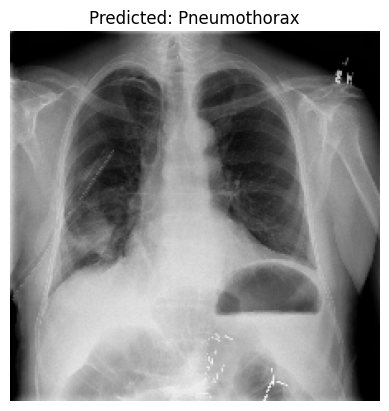

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Predicted class ResNet50: Pneumothorax


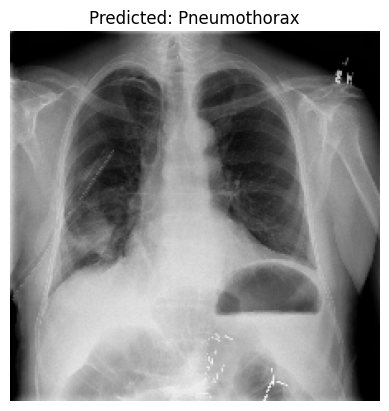

In [83]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image
    return img_array

# Function to make a prediction on a single image
def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class]
    return predicted_class_name, predictions

# Example usage
img_path = r"C:\Users\email\OneDrive - Lambton College\T3\PROJECT\2025W-T3 BDM 3035\Dataset\organized\Pneumothorax\00000744_006.png"
predicted_class_name, predictions = predict_image(model, img_path, class_names)
print(f"Predicted class EfficientNetB0: {predicted_class_name}")

# Optionally, display the image with the prediction
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()

predicted_class_name, predictions = predict_image(model2, img_path, class_names)
print(f"Predicted class ResNet50: {predicted_class_name}")

# Optionally, display the image with the prediction
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()


In [88]:
# Step 7: Save the model
model.save('C:/Users/email/OneDrive - Lambton College/T3/PROJECT/2025W-T3 BDM 3035/model/EfficientNetB0Model.h5')
print("Model saved as EfficientNetB0Model.h5")
model2.save('C:/Users/email/OneDrive - Lambton College/T3/PROJECT/2025W-T3 BDM 3035/model/ResNet50Model.h5')
print("Model saved as ResNet50Model.h5")


Model saved as EfficientNetB0Model.h5
Model saved as ResNet50Model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

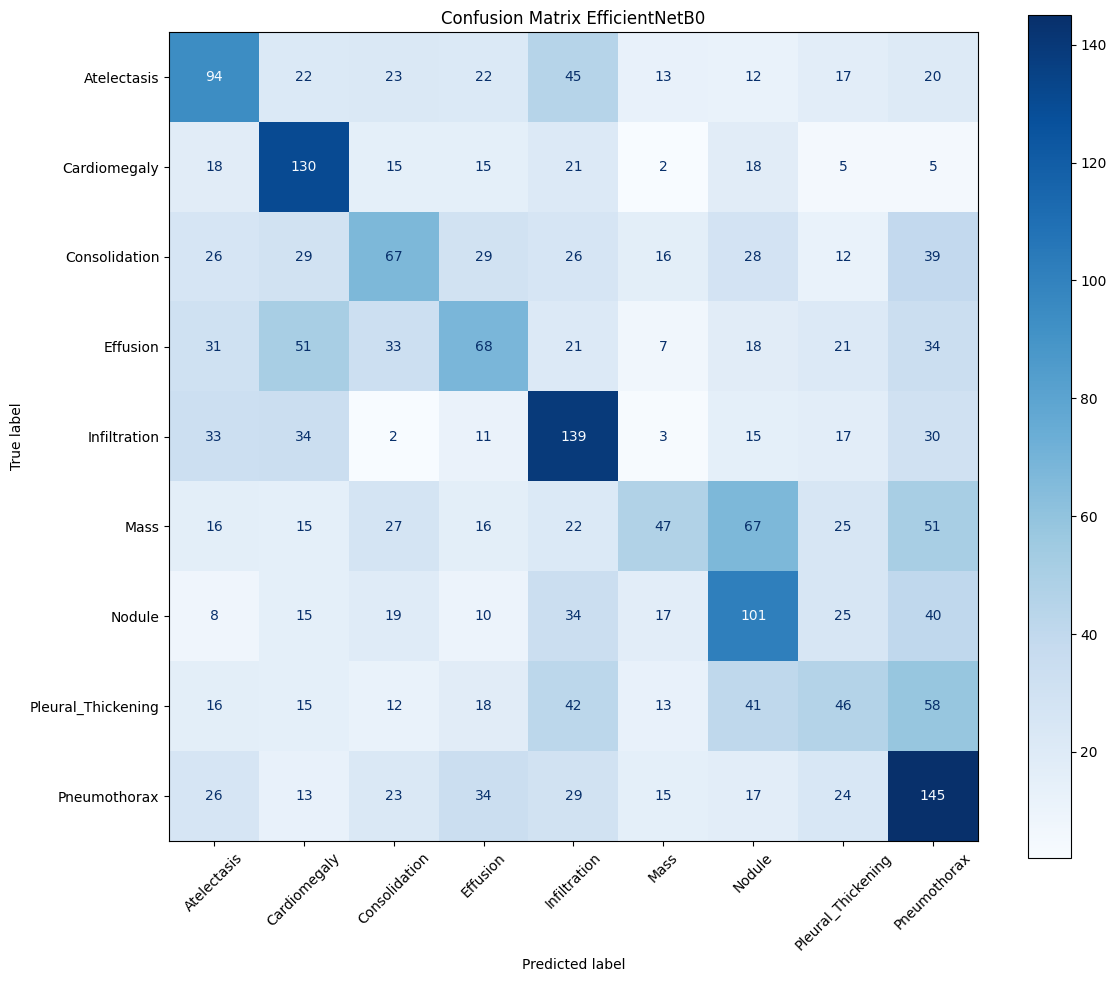

In [92]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Get true labels
y_true = []
y_pred = []

# Step 2: Iterate over validation dataset
for images, labels in validation_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))     # convert one-hot to class index
    y_pred.extend(np.argmax(preds, axis=1))              # predicted class index

# Step 3: Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))  # Increase figure size (adjust values as needed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Plot on the existing axes
plt.title("Confusion Matrix EfficientNetB0")
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better visibility
plt.tight_layout()       # Adjust layout to prevent clipping
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

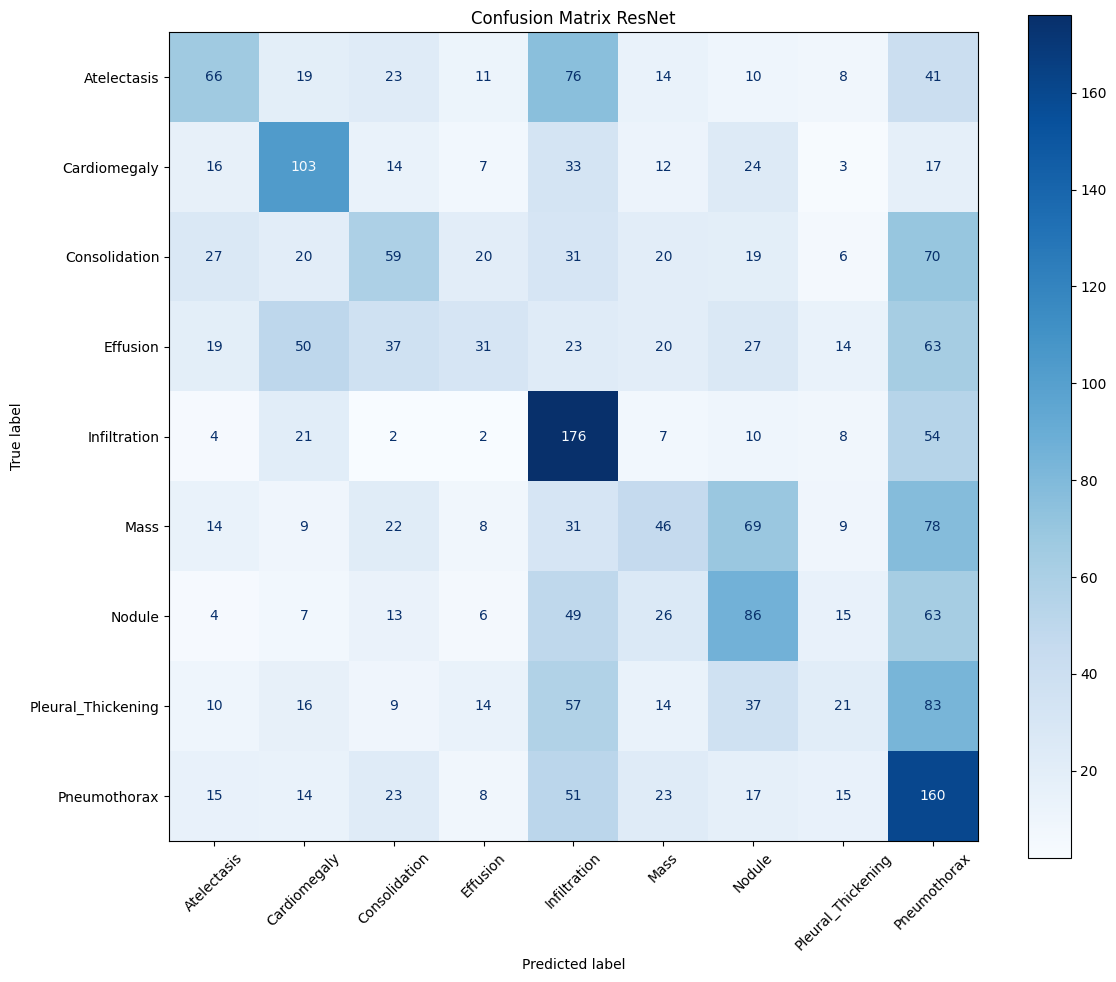

In [91]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Get true labels
y_true = []
y_pred = []

# Step 2: Iterate over validation dataset
for images, labels in validation_dataset:
    preds = model2.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))     # convert one-hot to class index
    y_pred.extend(np.argmax(preds, axis=1))              # predicted class index

# Step 3: Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))  # Increase figure size (adjust values as needed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Plot on the existing axes
plt.title("Confusion Matrix ResNet")
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better visibility
plt.tight_layout()       # Adjust layout to prevent clipping
plt.show()
